## ML - Final Project

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn import metrics as skm
from sklearn.linear_model import SGDClassifier

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Load the data
data = pd.read_csv('/content/drive/Shared drives/Machine Learning Course Project/home-credit-default-risk/application_train.csv', index_col = 0)

In [7]:
data.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## EDA

### Explore Data

In [8]:
# Check the number of rows and columns, and the data types
print("Data shape: \n", data.shape)
print("\n Data type: \n", data.dtypes.value_counts())

Data shape: 
 (307511, 121)

 Data type: 
 float64    65
int64      40
object     16
dtype: int64


In [9]:
# Explore the response variable
print("Missing values in Target: \n", data['TARGET'].isna().any())
print("\n Value counts in Target: \n", data['TARGET'].value_counts())
print("\n The ratio of minor class: \n", data['TARGET'].value_counts()[1]/len(data))

Missing values in Target: 
 False

 Value counts in Target: 
 0    282686
1     24825
Name: TARGET, dtype: int64

 The ratio of minor class: 
 0.08072881945686496


### Univariate Analysis

In [10]:
# Univariate analysis for categorical feature
categorical = data.dtypes[data.dtypes == 'object'].index
data_c = data[categorical]

numerical = data.dtypes[data.dtypes != 'object'].index
data_num = data[numerical]

In [11]:
# Define function to conduct univariate analysis
def draw_histograms(df, variables, n_rows, n_cols, size):
  fig = plt.figure(figsize=size)
  for i, var_name in enumerate(variables):
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    df[var_name].hist(bins = 10, ax = ax, grid = False)
    ax.set_title(var_name)
    if df[var_name].dtypes == 'object':
      plt.xticks(rotation = 90)
  plt.subplots_adjust(hspace = 1.5)
  plt.show()

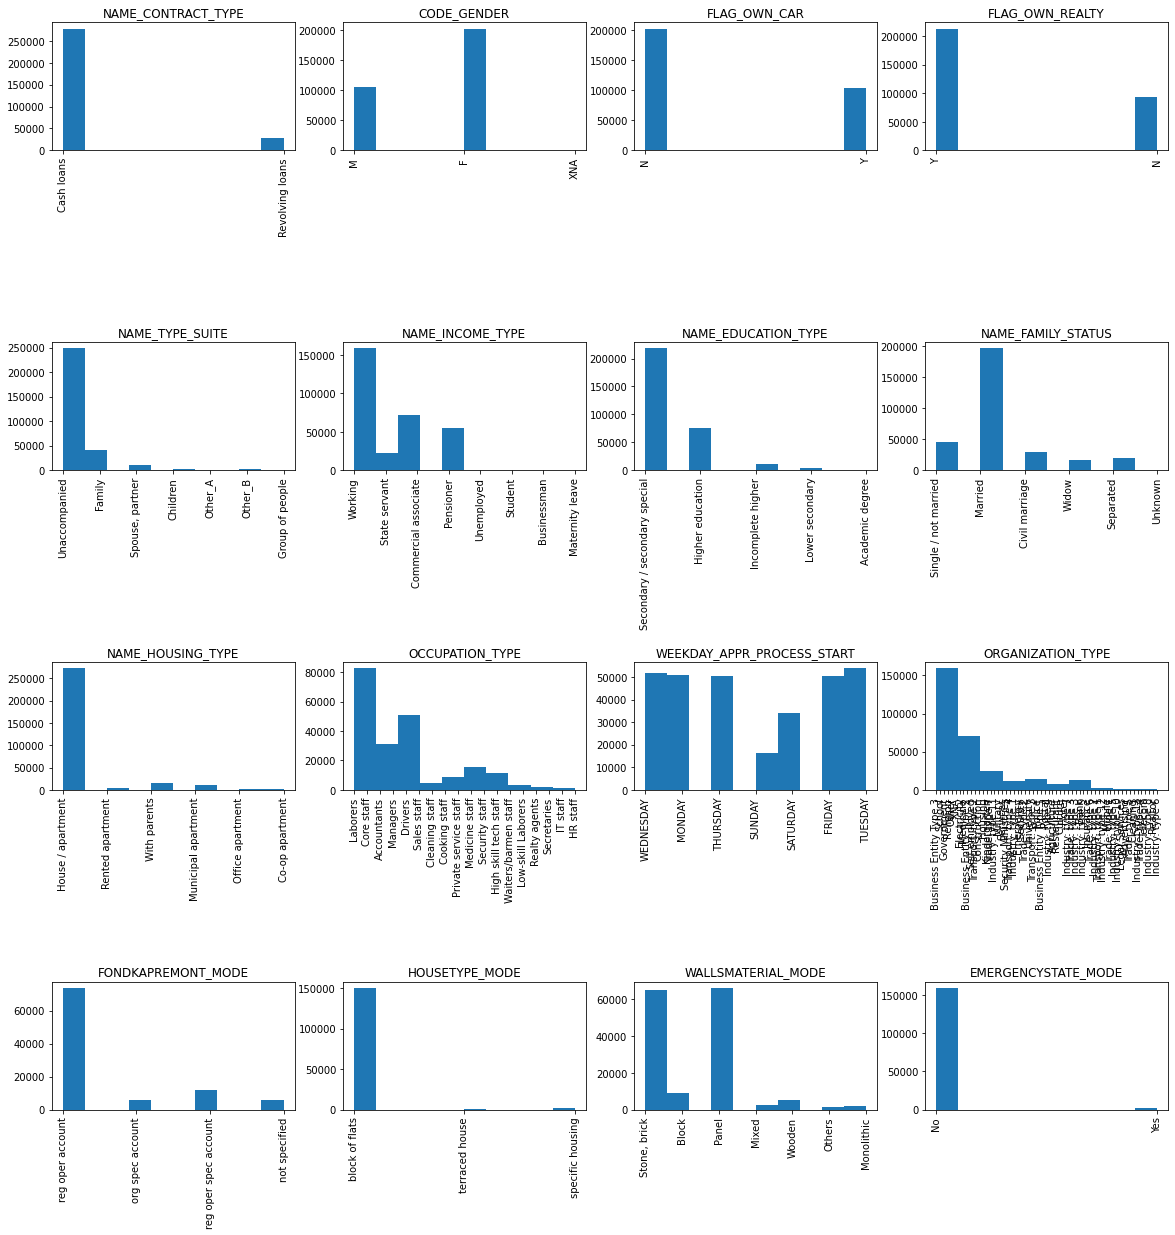

In [12]:
# Draw histogram for categorical variables
draw_histograms(data_c, data_c.columns, 4, 4, [20, 20])

Multiple levels of some categorical variable needs to be combined

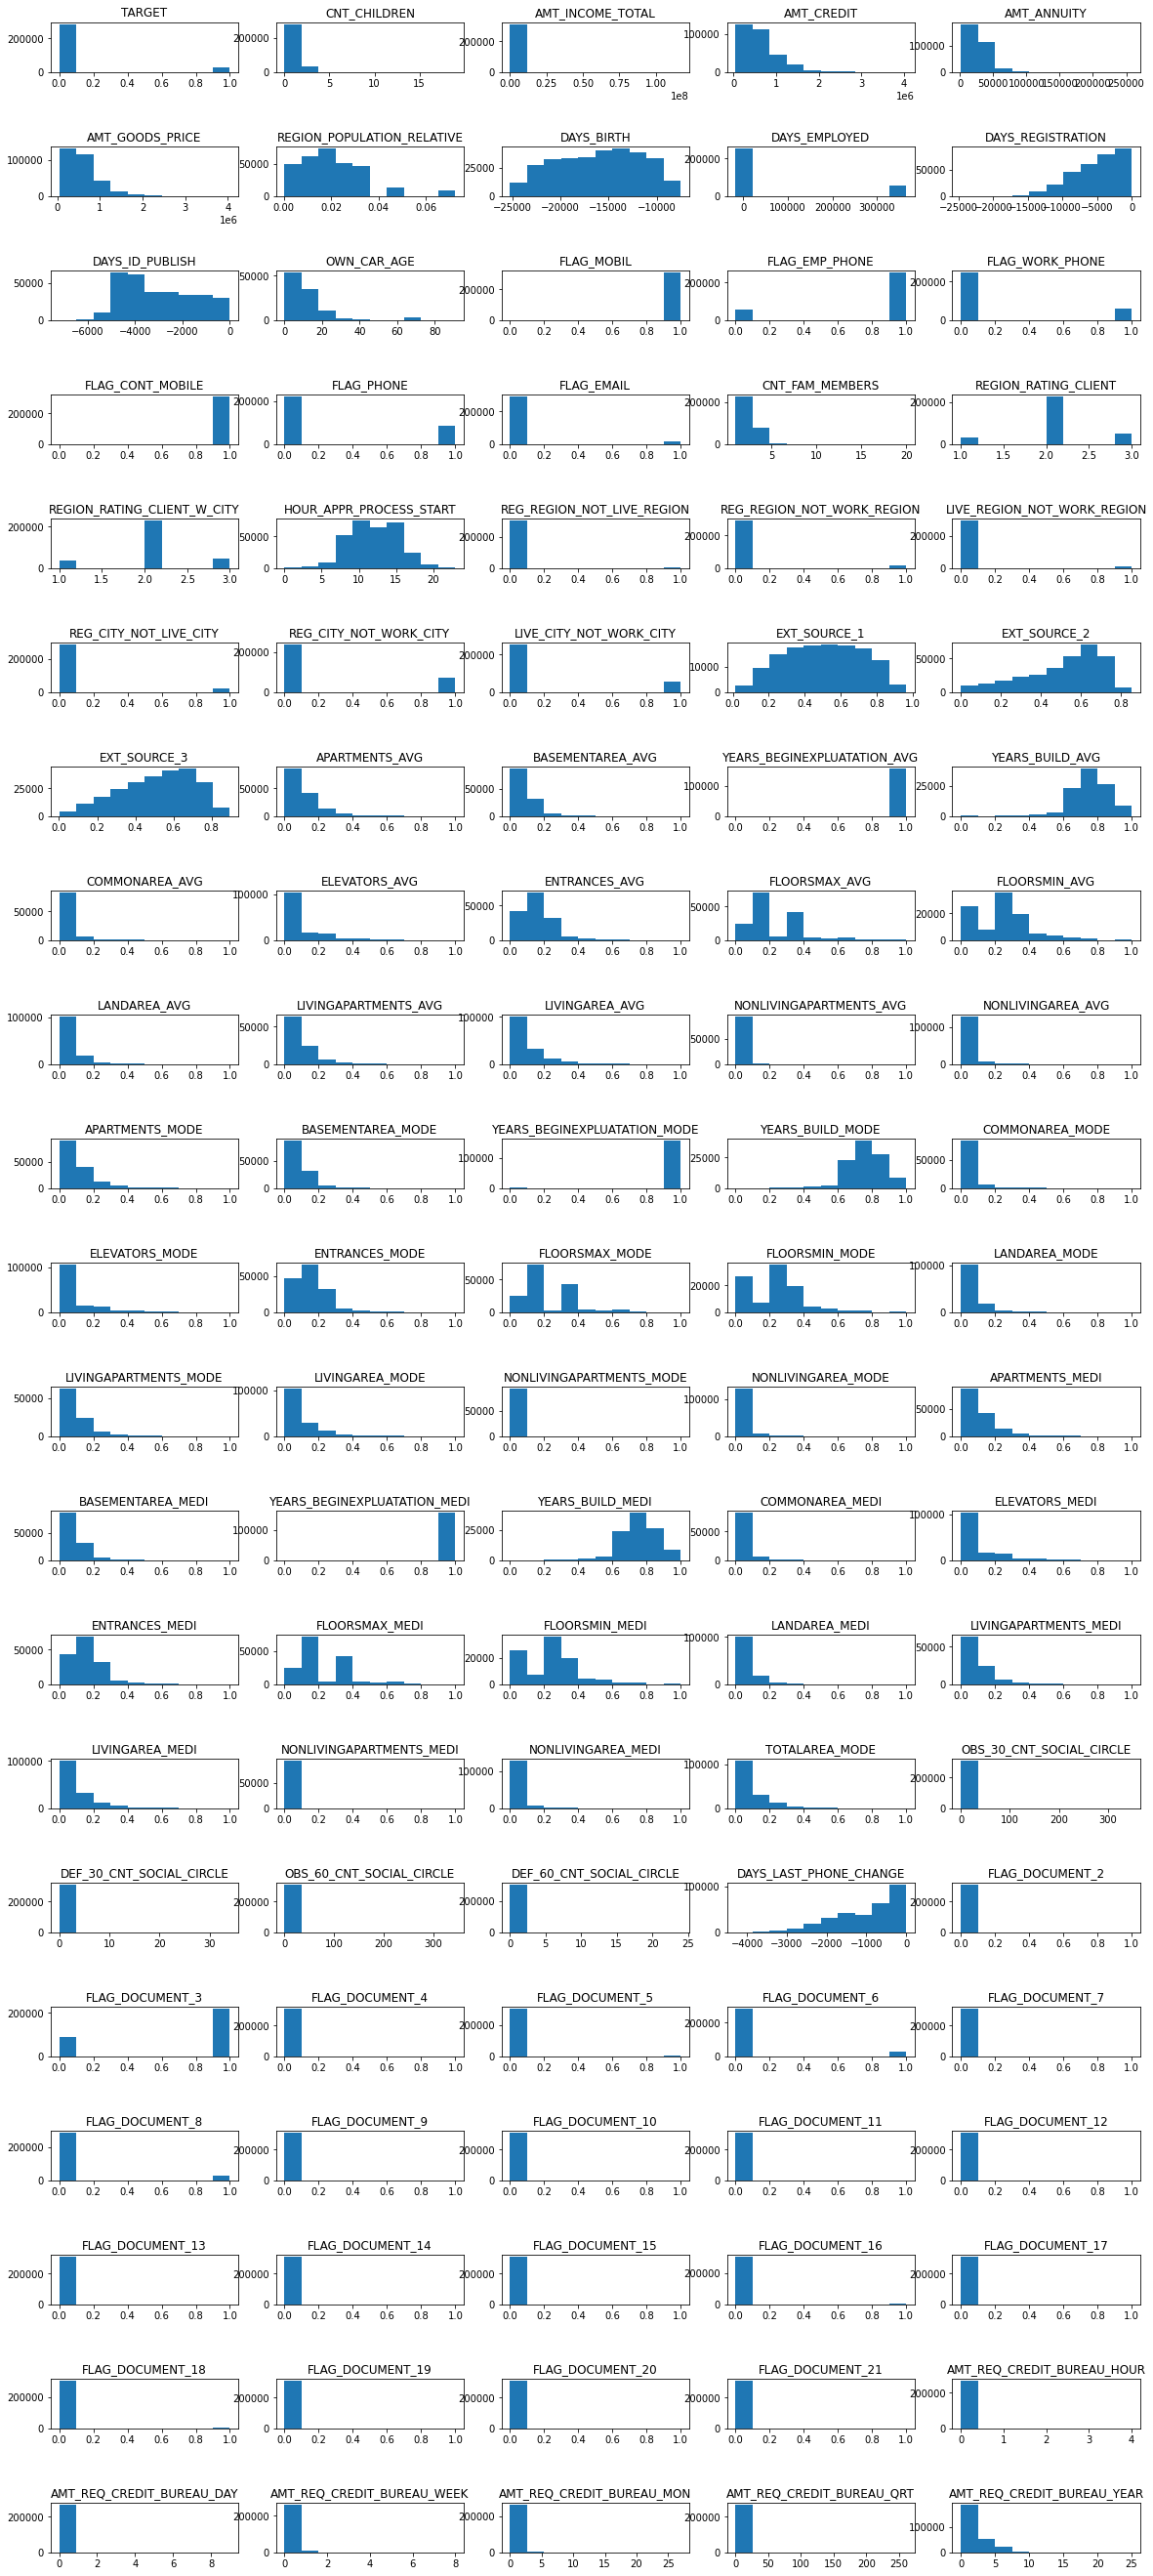

In [13]:
# Draw histogram for numerical variable
draw_histograms(data_num, data_num.columns, 22, 5, [20, 50])

### Bivariate Analysis

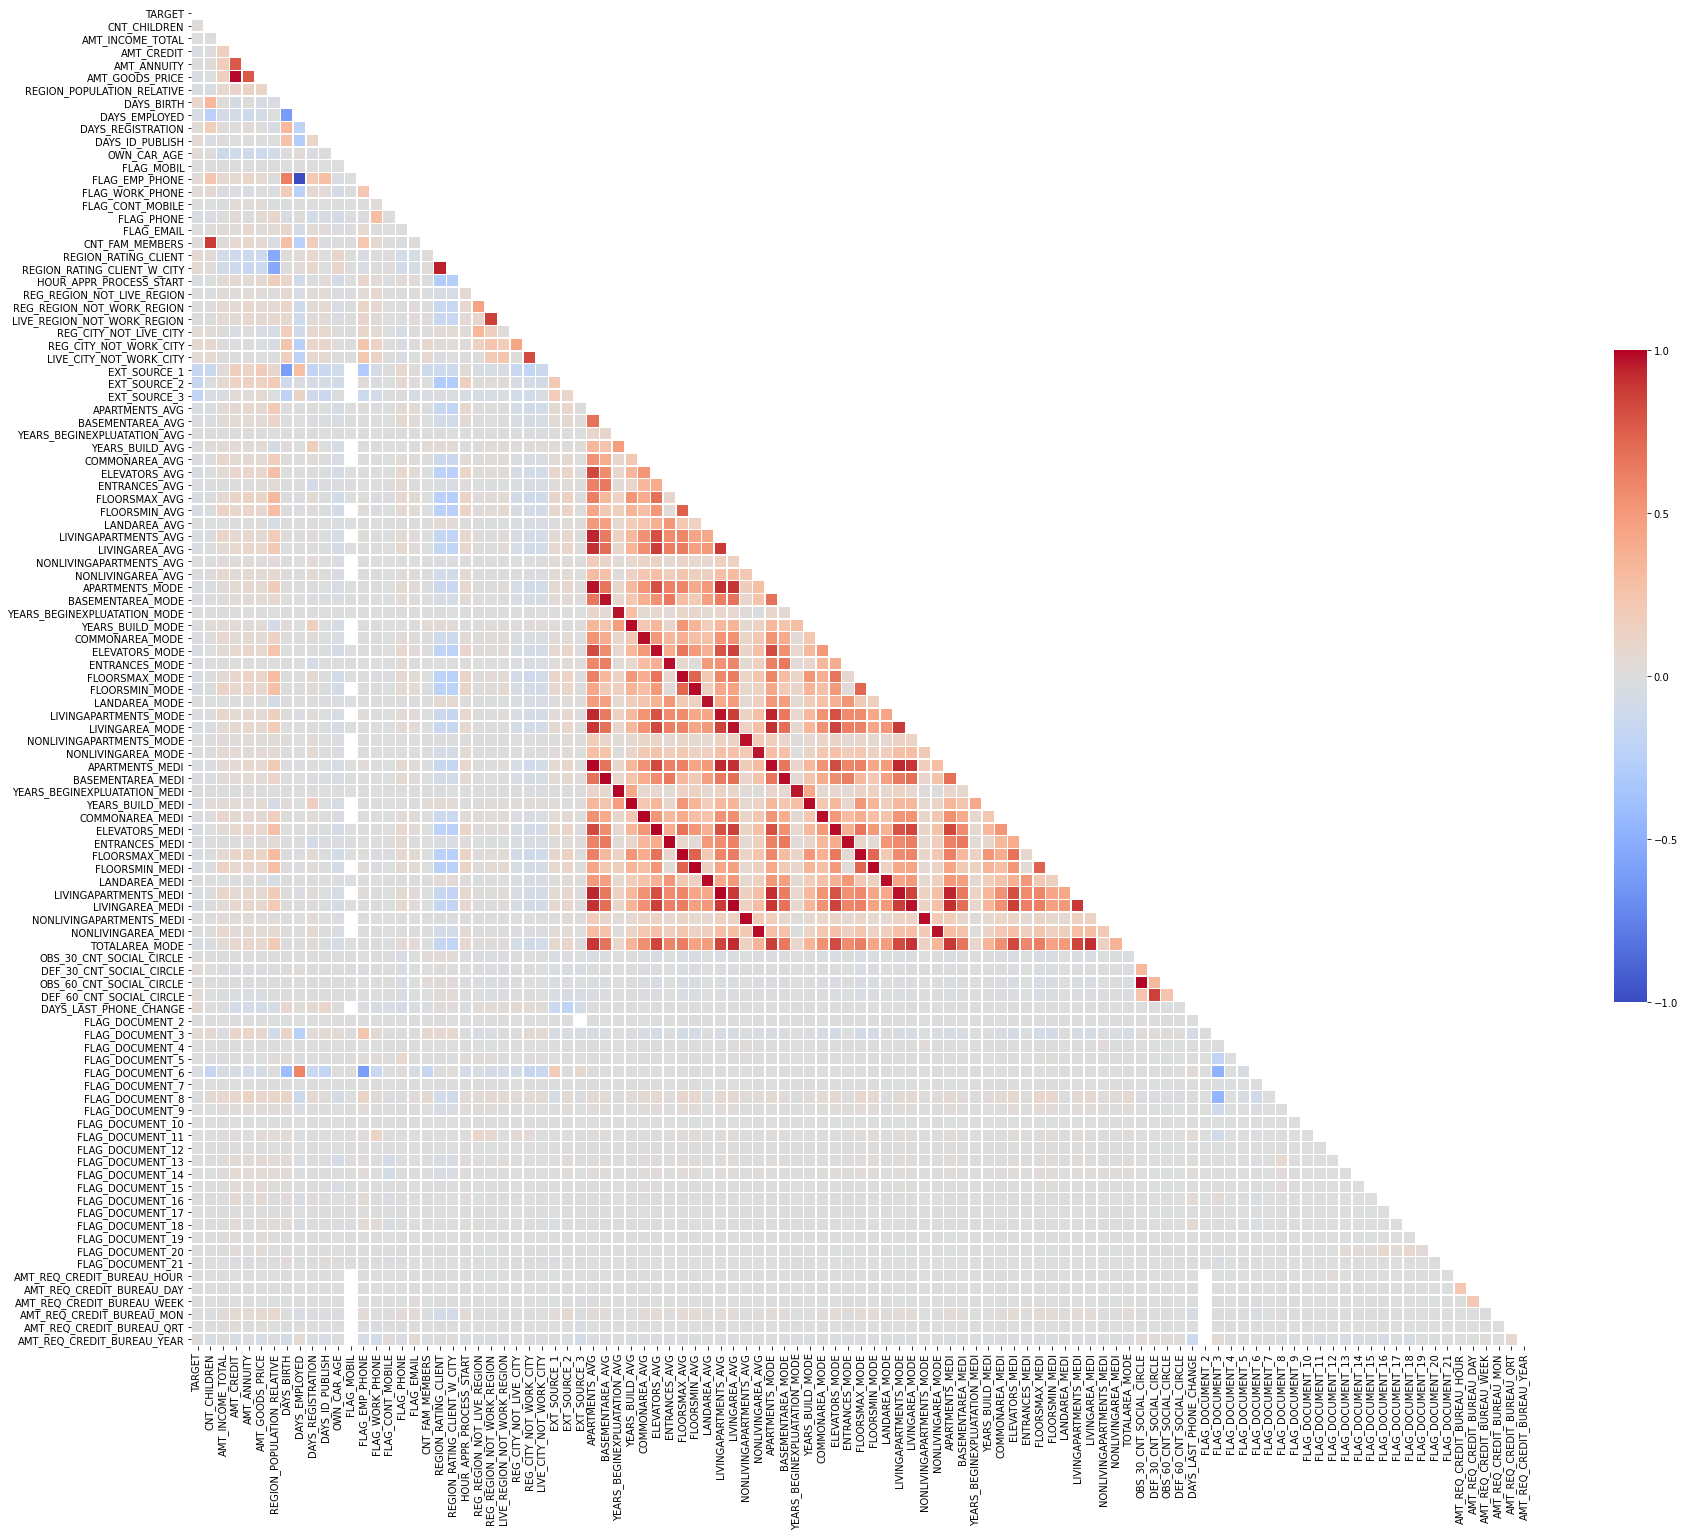

In [14]:
correlation = data.corr()

mask = np.zeros_like(correlation.iloc[:121,:121], dtype=np.bool)              # Create an array of zeros with the same shape and type as a given array.
mask[np.triu_indices_from(mask)] = True                                          # Set the indices for the upper-triangle of array to be True

f, ax = plt.subplots(figsize=(30, 30))

heatmap = sns.heatmap(correlation.iloc[:121,:121],
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = False,
                      annot_kws = {'size': 12})

#add the column names as labels
ax.set_yticklabels(correlation.iloc[:121,:121].columns, rotation = 0)
ax.set_xticklabels(correlation.iloc[:121,:121].columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

It seems like some features are highly correlated. We will explore later to decide which feature to drop

### Missing Values

In [15]:
# Check missing values for each columns
missing_values = pd.DataFrame(data.isnull().sum()/len(data), columns =['missing value rate'])

# Display all the missing values
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  display(missing_values.sort_values(ascending = False, by = 'missing value rate'))

,missing value rate
COMMONAREA_AVG,0.698723
COMMONAREA_MODE,0.698723
COMMONAREA_MEDI,0.698723
NONLIVINGAPARTMENTS_AVG,0.694330
NONLIVINGAPARTMENTS_MODE,0.694330
NONLIVINGAPARTMENTS_MEDI,0.694330
FONDKAPREMONT_MODE,0.683862
LIVINGAPARTMENTS_MEDI,0.683550
LIVINGAPARTMENTS_AVG,0.683550
LIVINGAPARTMENTS_MODE,0.683550


#### Check columns with missing value rate > 0.15

In [16]:
# Columns with missing value rate above 0.3
missing_values[missing_values['missing value rate'] > 0.15].index

Index(['OWN_CAR_AGE', 'OCCUPATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_3',
       'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI',
       'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
       'LIVINGAREA_MEDI', 'NONLIVINGAPARTMEN

##### Column: 'OWN_CAR_AGE'

In [17]:
# Check missing values in column car age
print("Missing values:", data['OWN_CAR_AGE'].isna().sum(axis = 0))

# Check how many of the missing values has N in the column FLAG_OWN_CAR
car = data.loc[data['FLAG_OWN_CAR'] == 'N', 'OWN_CAR_AGE']
print("Missing values with N in the column FLAG_OWN_CAR:", car.shape[0])

Missing values: 202929
Missing values with N in the column FLAG_OWN_CAR: 202924


We can see most na in column OWN_CAR_AGE is because people don't have cars, total 202924 rows. We will just keep this column and encode those na values

##### Column: OCCUPATION TYPE

In [18]:
# Deal with OCCUPATION TYPE
# Choose the subset where columns OCCUPATION TYPE contains na
ocp = data.loc[data['OCCUPATION_TYPE'].isna()]
ocp.shape

(96391, 121)

In [19]:
# Separate data into categorical and numerical variables
categorical = ocp.dtypes[ocp.dtypes == 'object'].index
ocp_c = ocp[categorical]

numerical = ocp.dtypes[ocp.dtypes != 'object'].index
ocp_num = ocp[numerical]

In [20]:
# Plot histogram for categorical variables
# draw_histograms(ocp_c, ocp_c.columns, 4, 4, [20, 20])

In [21]:
# draw_histograms(ocp_num, ocp_num.columns, 22, 5, [20, 50])

In [22]:
# We can see many Pensioner left this column na, total 55357 rows
ocp['NAME_INCOME_TYPE'].value_counts()

Pensioner               55357
Working                 24920
Commercial associate    12297
State servant            3787
Unemployed                 22
Student                     5
Businessman                 2
Maternity leave             1
Name: NAME_INCOME_TYPE, dtype: int64

In [23]:
# How many missing values left, if we fill OCCUPATION_TYPE with Retired for Pensioner
ocp.loc[ocp['NAME_INCOME_TYPE'] != 'Pensioner'].shape[0]/len(data)

0.13343912900676724

There will be only 13% missing value in this column if we fill this column with 'Retired' for pensioner. The ratio is below our threshold. So we will keep this column as well.

##### Column: EXT_SOURCE_1

In [24]:
# Deal with 'EXT_SOURCE_1'
# Choose the subset where columns 'EXT_SOURCE_1' contains na
ext1 = data.loc[data['EXT_SOURCE_1'].isna()]
ext1.shape

(173378, 121)

In [25]:
# Separate data into categorical and numerical variables and plot histogram
categorical = ext1.dtypes[ext1.dtypes == 'object'].index
ext1_c = ext1[categorical]

numerical = ext1.dtypes[ext1.dtypes != 'object'].index
ext1_num = ext1[numerical]

In [26]:
# draw_histograms(ext1_c, ext1_c.columns, 4, 4, [20, 20])

In [27]:
# draw_histograms(ext1_num, ext1_num.columns, 22, 5, [20, 50])

From the histograms, We did not see any structural defficiency and particular pattern in the missing values. Assume the missing value in this column is missing at random and will drop it later.

##### Column: EXT_SOURCE_3

In [28]:
# Deal with 'EXT_SOURCE_3'
# Choose the subset where columns 'EXT_SOURCE_3' contains na
ext3 = data.loc[data['EXT_SOURCE_3'].isna()]
ext3.shape

(60965, 121)

In [29]:
# Separate data into categorical and numerical variables and plot histogram
categorical = ext3.dtypes[ext3.dtypes == 'object'].index
ext3_c = ext3[categorical]

numerical = ext3.dtypes[ext3.dtypes != 'object'].index
ext3_num = ext3[numerical]

In [30]:
# draw_histograms(ext3_c, ext3_c.columns, 4, 4, [20, 20])

In [31]:
# draw_histograms(ext3_num, ext3_num.columns, 22, 5, [20, 50])

The same reason for EXT_SOURCE_3, and we will drop it later

##### Columns related to house / apartment

In [32]:
# All the columns related to house
col_lst = ['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 
'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 
'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 
'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE',
'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE','EMERGENCYSTATE_MODE']

In [33]:
# Get the index of rows that have at least one missing value in those columns
na_val = data.isna()
na_idx = na_val[na_val[col_lst].sum(axis = 1)>0].index

In [34]:
# Get all the data that have at least one missing value in those house related columns
house = data.loc[na_idx]

In [35]:
# Separate data into categorical and numerical variables and plot histogram
categorical = house.dtypes[house.dtypes == 'object'].index
hse_c = house[categorical]

numerical = house.dtypes[house.dtypes != 'object'].index
hse_num = house[numerical]

In [36]:
# draw_histograms(hse_c, hse_c.columns, 4, 4, [20, 20])
# draw_histograms(hse_num, hse_num.columns, 22, 5, [20, 50])

We did not see any structural deficiency and specific causes. So let's assume the missing value in those columns are missing at random

## Feature Engineering

### Drop Columns

#### Drop columns with missing value rate greater than 0.15

In [37]:
# Compile the columns that need to be dropped
col_lst.append('EXT_SOURCE_1')
col_lst.append('EXT_SOURCE_3')

In [38]:
new_data = data.drop(col_lst, axis = 1)

In [39]:
# Check missing values for each columns, and also notice that we need to keep columns OWN_CAR_AGE and OCCUPATION_TYPE
missing_values1 = pd.DataFrame(new_data.isnull().sum()/len(new_data), columns =['missing value rate'])
missing_values1.sort_values(ascending = False, by = 'missing value rate')[0:5]

,missing value rate
OWN_CAR_AGE,0.659908
OCCUPATION_TYPE,0.313455
AMT_REQ_CREDIT_BUREAU_YEAR,0.135016
AMT_REQ_CREDIT_BUREAU_QRT,0.135016
AMT_REQ_CREDIT_BUREAU_MON,0.135016


#### Drop columns with too many missing values while the related target is 1 

In [40]:
# Create subset of new_data with TARGET = 1
minor = new_data[new_data['TARGET'] == 1]

In [41]:
# Check the missing values for each columns
minor.isna().sum(axis = 0).sort_values(ascending = False)[0:15]

OWN_CAR_AGE                   17249
OCCUPATION_TYPE                6278
AMT_REQ_CREDIT_BUREAU_HOUR     4292
AMT_REQ_CREDIT_BUREAU_QRT      4292
AMT_REQ_CREDIT_BUREAU_YEAR     4292
AMT_REQ_CREDIT_BUREAU_DAY      4292
AMT_REQ_CREDIT_BUREAU_WEEK     4292
AMT_REQ_CREDIT_BUREAU_MON      4292
NAME_TYPE_SUITE                  70
EXT_SOURCE_2                     52
DEF_60_CNT_SOCIAL_CIRCLE         36
OBS_60_CNT_SOCIAL_CIRCLE         36
DEF_30_CNT_SOCIAL_CIRCLE         36
OBS_30_CNT_SOCIAL_CIRCLE         36
AMT_GOODS_PRICE                  21
dtype: int64

In [42]:
# Check the missing value rate of column AMT_REQ_CREDIT_BUREAU_HOUR for TARGET = 1
minor['AMT_REQ_CREDIT_BUREAU_HOUR'].isna().sum()/len(minor)

0.17289023162134945

In [43]:
# Check the missing value rate of column AMT_REQ_CREDIT_BUREAU_HOUR for TARGET = 0
data[data['TARGET'] == 0]['AMT_REQ_CREDIT_BUREAU_HOUR'].isna().sum()/len(data[data['TARGET'] == 0])

0.1316902853342578

There is no significant difference in the missing value rate between TARGET 1 and TARGET 0, so we will drop those columns.

In [44]:
# Drop columns
cols_lst2 = ['AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_DAY', 
             'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_QRT']

new_data = new_data.drop(cols_lst2, axis = 1)

In [45]:
new_data.isna().sum(axis = 0).sort_values(ascending = False)[0:10]

OWN_CAR_AGE                 202929
OCCUPATION_TYPE              96391
NAME_TYPE_SUITE               1292
DEF_60_CNT_SOCIAL_CIRCLE      1021
OBS_60_CNT_SOCIAL_CIRCLE      1021
DEF_30_CNT_SOCIAL_CIRCLE      1021
OBS_30_CNT_SOCIAL_CIRCLE      1021
EXT_SOURCE_2                   660
AMT_GOODS_PRICE                278
AMT_ANNUITY                     12
dtype: int64

#### Drop columns that are highly correlated

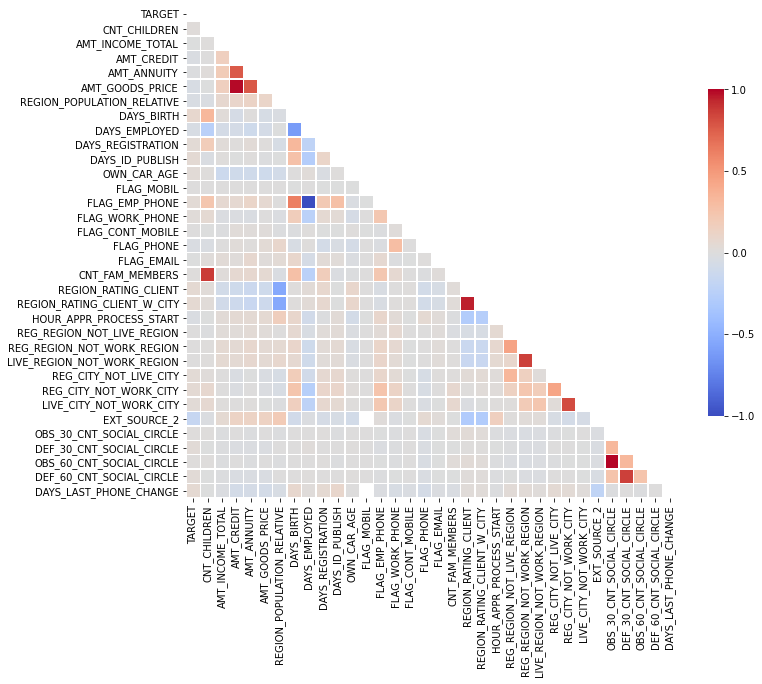

In [46]:
corr_score_new = new_data.corr()

mask = np.zeros_like(corr_score_new.iloc[:34,:34], dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(11, 15))

heatmap = sns.heatmap(corr_score_new.iloc[:34,:34],
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = False,
                      annot_kws = {'size': 12})

#add the column names as labels
ax.set_yticklabels(corr_score_new.iloc[:34,:34].columns, rotation = 0)
ax.set_xticklabels(corr_score_new.iloc[:34,:34].columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [47]:
# Define function to print out the top 5 positive correlated features and 5 negative correlated features
def corr_top5(x):
  pos_corr = x.sort_values(ascending = False)[0:5]
  neg_corr = x.sort_values()[0:5]
  print("Positive Correlation:")
  print(pos_corr)
  print("\nNegative Correlation:")
  print(neg_corr)

In [48]:
corr_top5(corr_score_new['AMT_CREDIT'])

Positive Correlation:
AMT_CREDIT          1.000000
AMT_GOODS_PRICE     0.986968
AMT_ANNUITY         0.770138
AMT_INCOME_TOTAL    0.156870
EXT_SOURCE_2        0.131228
Name: AMT_CREDIT, dtype: float64

Negative Correlation:
REGION_RATING_CLIENT_W_CITY   -0.110915
REGION_RATING_CLIENT          -0.101776
OWN_CAR_AGE                   -0.094191
DAYS_LAST_PHONE_CHANGE        -0.073701
DAYS_EMPLOYED                 -0.066838
Name: AMT_CREDIT, dtype: float64


In [49]:
corr_top5(corr_score_new['CNT_FAM_MEMBERS'])

Positive Correlation:
CNT_FAM_MEMBERS      1.000000
CNT_CHILDREN         0.879161
DAYS_BIRTH           0.278894
FLAG_EMP_PHONE       0.233950
DAYS_REGISTRATION    0.173416
Name: CNT_FAM_MEMBERS, dtype: float64

Negative Correlation:
DAYS_EMPLOYED                -0.233549
FLAG_DOCUMENT_6              -0.156682
DAYS_LAST_PHONE_CHANGE       -0.027108
REGION_POPULATION_RELATIVE   -0.024209
DAYS_ID_PUBLISH              -0.020912
Name: CNT_FAM_MEMBERS, dtype: float64


In [50]:
corr_top5(corr_score_new['FLAG_EMP_PHONE'])

Positive Correlation:
FLAG_EMP_PHONE            1.000000
DAYS_BIRTH                0.619888
DAYS_ID_PUBLISH           0.273611
REG_CITY_NOT_WORK_CITY    0.256427
FLAG_DOCUMENT_3           0.248534
Name: FLAG_EMP_PHONE, dtype: float64

Negative Correlation:
DAYS_EMPLOYED                 -0.999755
FLAG_DOCUMENT_6               -0.597732
REGION_RATING_CLIENT_W_CITY   -0.034712
REGION_RATING_CLIENT          -0.032871
OWN_CAR_AGE                   -0.028282
Name: FLAG_EMP_PHONE, dtype: float64


In [51]:
corr_top5(corr_score_new['REGION_RATING_CLIENT_W_CITY'])

Positive Correlation:
REGION_RATING_CLIENT_W_CITY    1.000000
REGION_RATING_CLIENT           0.950842
OWN_CAR_AGE                    0.088820
DAYS_REGISTRATION              0.074038
FLAG_DOCUMENT_3                0.067083
Name: REGION_RATING_CLIENT_W_CITY, dtype: float64

Negative Correlation:
REGION_POPULATION_RELATIVE    -0.531535
EXT_SOURCE_2                  -0.288299
HOUR_APPR_PROCESS_START       -0.264815
AMT_ANNUITY                   -0.141682
LIVE_REGION_NOT_WORK_REGION   -0.140771
Name: REGION_RATING_CLIENT_W_CITY, dtype: float64


In [52]:
corr_top5(corr_score_new['LIVE_REGION_NOT_WORK_REGION'])

Positive Correlation:
LIVE_REGION_NOT_WORK_REGION    1.000000
REG_REGION_NOT_WORK_REGION     0.860627
LIVE_CITY_NOT_WORK_CITY        0.236635
REG_CITY_NOT_WORK_CITY         0.185863
FLAG_EMP_PHONE                 0.096447
Name: LIVE_REGION_NOT_WORK_REGION, dtype: float64

Negative Correlation:
REGION_RATING_CLIENT          -0.146561
REGION_RATING_CLIENT_W_CITY   -0.140771
DAYS_EMPLOYED                 -0.095539
FLAG_DOCUMENT_6               -0.059148
OWN_CAR_AGE                   -0.028980
Name: LIVE_REGION_NOT_WORK_REGION, dtype: float64


In [53]:
corr_top5(corr_score_new['LIVE_CITY_NOT_WORK_CITY'])

Positive Correlation:
LIVE_CITY_NOT_WORK_CITY        1.000000
REG_CITY_NOT_WORK_CITY         0.825575
LIVE_REGION_NOT_WORK_REGION    0.236635
FLAG_EMP_PHONE                 0.219219
REG_REGION_NOT_WORK_REGION     0.197097
Name: LIVE_CITY_NOT_WORK_CITY, dtype: float64

Negative Correlation:
DAYS_EMPLOYED          -0.218101
FLAG_DOCUMENT_6        -0.133229
EXT_SOURCE_2           -0.058900
FLAG_PHONE             -0.023580
REGION_RATING_CLIENT   -0.019154
Name: LIVE_CITY_NOT_WORK_CITY, dtype: float64


In [54]:
corr_top5(corr_score_new['OBS_30_CNT_SOCIAL_CIRCLE'])

Positive Correlation:
OBS_30_CNT_SOCIAL_CIRCLE    1.000000
OBS_60_CNT_SOCIAL_CIRCLE    0.998490
DEF_30_CNT_SOCIAL_CIRCLE    0.329338
DEF_60_CNT_SOCIAL_CIRCLE    0.253499
REGION_RATING_CLIENT        0.034330
Name: OBS_30_CNT_SOCIAL_CIRCLE, dtype: float64

Negative Correlation:
FLAG_PHONE                    -0.033484
REG_REGION_NOT_WORK_REGION    -0.028855
FLAG_DOCUMENT_8               -0.023339
LIVE_REGION_NOT_WORK_REGION   -0.023147
REG_REGION_NOT_LIVE_REGION    -0.020641
Name: OBS_30_CNT_SOCIAL_CIRCLE, dtype: float64


In [55]:
corr_top5(corr_score_new['DEF_30_CNT_SOCIAL_CIRCLE'])

Positive Correlation:
DEF_30_CNT_SOCIAL_CIRCLE    1.000000
DEF_60_CNT_SOCIAL_CIRCLE    0.860517
OBS_60_CNT_SOCIAL_CIRCLE    0.331571
OBS_30_CNT_SOCIAL_CIRCLE    0.329338
TARGET                      0.032248
Name: DEF_30_CNT_SOCIAL_CIRCLE, dtype: float64

Negative Correlation:
EXT_SOURCE_2      -0.030406
FLAG_PHONE        -0.029758
AMT_ANNUITY       -0.022833
AMT_GOODS_PRICE   -0.022244
AMT_CREDIT        -0.021229
Name: DEF_30_CNT_SOCIAL_CIRCLE, dtype: float64


##### Define the magnitude of correlation:
The absolute value of correlation:
Weak: 0.0 ~ 0.3, Medium: 0.3 ~ 0.7, Strong: 0.7 ~ 1.0

We will drop columns that have strong correlations.

In [56]:
# Drop highly correlated columns
cols_lst3 = ['AMT_GOODS_PRICE', 'AMT_ANNUITY', 'CNT_CHILDREN', 'DAYS_EMPLOYED', 'REGION_RATING_CLIENT', 'REG_REGION_NOT_WORK_REGION',
            'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'REG_CITY_NOT_WORK_CITY']

new_data = new_data.drop(cols_lst3, axis = 1)

In [57]:
new_data.shape

(307511, 57)

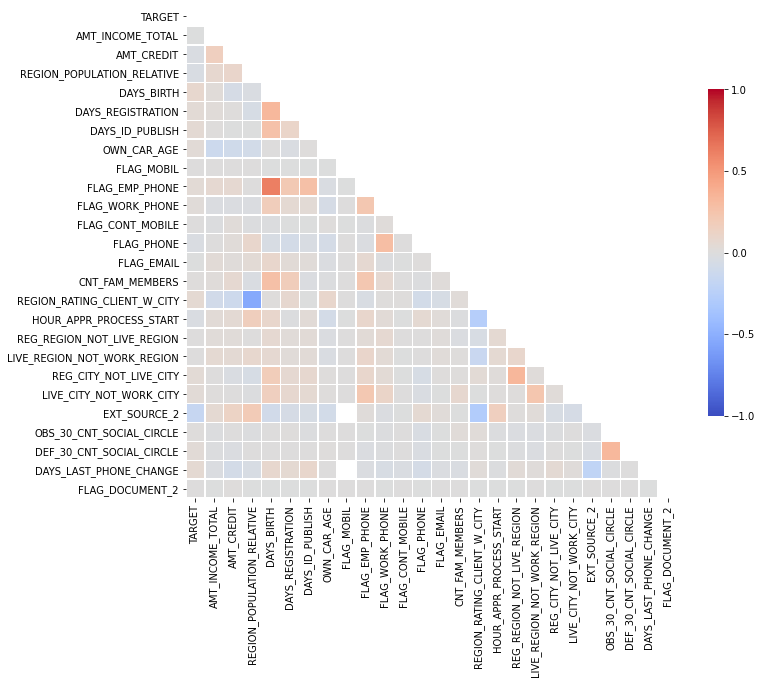

In [58]:
corr_score_new1 = new_data.corr()

mask = np.zeros_like(corr_score_new1.iloc[:26,:26], dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(11, 15))

heatmap = sns.heatmap(corr_score_new1.iloc[:26,:26],
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = False,
                      annot_kws = {'size': 12})

#add the column names as labels
ax.set_yticklabels(corr_score_new1.iloc[:26,:26].columns, rotation = 0)
ax.set_xticklabels(corr_score_new1.iloc[:26,:26].columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

### Drop Rows

#### Drop rows, which target = 0 and have missing values in columns

In [59]:
# Create subset of new_data with TARGET = 0
major = new_data[new_data['TARGET'] == 0]

In [60]:
# Check the missing values for each columns
major.isna().sum(axis = 0).sort_values(ascending = False)[0:15]

OWN_CAR_AGE                 185680
OCCUPATION_TYPE              90113
NAME_TYPE_SUITE               1222
OBS_30_CNT_SOCIAL_CIRCLE       985
DEF_30_CNT_SOCIAL_CIRCLE       985
EXT_SOURCE_2                   608
CNT_FAM_MEMBERS                  2
DAYS_LAST_PHONE_CHANGE           1
DAYS_ID_PUBLISH                  0
FLAG_EMAIL                       0
FLAG_PHONE                       0
FLAG_CONT_MOBILE                 0
FLAG_WORK_PHONE                  0
FLAG_EMP_PHONE                   0
FLAG_MOBIL                       0
dtype: int64

In [61]:
# Drop rows with missing values in NAME_TYPE_SUITE 
drop_idx0 = major[major['NAME_TYPE_SUITE'].isna()].index
new_data = new_data.drop(drop_idx0, axis = 0)

In [62]:
# Drop rows with missing values in OBS_30_CNT_SOCIAL_CIRCLE
drop_idx1 = major[major['OBS_30_CNT_SOCIAL_CIRCLE'].isna()].index
new_data = new_data.drop(drop_idx1, axis = 0)

In [63]:
# Re-run those code to update the major
major = new_data[new_data['TARGET'] == 0]
major.isna().sum(axis = 0).sort_values(ascending = False)[0:15]

OWN_CAR_AGE               184218
OCCUPATION_TYPE            89433
EXT_SOURCE_2                 603
DAYS_LAST_PHONE_CHANGE         1
FLAG_DOCUMENT_21               0
DAYS_REGISTRATION              0
CNT_FAM_MEMBERS                0
FLAG_EMAIL                     0
FLAG_PHONE                     0
FLAG_CONT_MOBILE               0
FLAG_WORK_PHONE                0
FLAG_EMP_PHONE                 0
FLAG_MOBIL                     0
DAYS_ID_PUBLISH                0
DAYS_BIRTH                     0
dtype: int64

In [64]:
# Drop rows with missing values in EXT_SOURCE_2
drop_idx2 = major[major['EXT_SOURCE_2'].isna()].index
new_data = new_data.drop(drop_idx2, axis = 0)

In [65]:
# Re-run those code to update the major
major = new_data[new_data['TARGET'] == 0]
major.isna().sum(axis = 0).sort_values(ascending = False)[0:15]

OWN_CAR_AGE                    183789
OCCUPATION_TYPE                 89199
FLAG_DOCUMENT_21                    0
HOUR_APPR_PROCESS_START             0
REGION_RATING_CLIENT_W_CITY         0
CNT_FAM_MEMBERS                     0
FLAG_EMAIL                          0
FLAG_PHONE                          0
FLAG_CONT_MOBILE                    0
FLAG_WORK_PHONE                     0
FLAG_EMP_PHONE                      0
FLAG_MOBIL                          0
DAYS_ID_PUBLISH                     0
DAYS_REGISTRATION                   0
DAYS_BIRTH                          0
dtype: int64

In [66]:
# Drop rows with missing values in EXT_SOURCE_2
drop_idx2 = major[major['EXT_SOURCE_2'].isna()].index
new_data = new_data.drop(drop_idx2, axis = 0)

In [67]:
# OWN_CAR_AGE and OCCUPATION_TYPE are columns we need to impute
major = new_data[new_data['TARGET'] == 0]
major.isna().sum(axis = 0).sort_values(ascending = False)[0:15]

OWN_CAR_AGE                    183789
OCCUPATION_TYPE                 89199
FLAG_DOCUMENT_21                    0
HOUR_APPR_PROCESS_START             0
REGION_RATING_CLIENT_W_CITY         0
CNT_FAM_MEMBERS                     0
FLAG_EMAIL                          0
FLAG_PHONE                          0
FLAG_CONT_MOBILE                    0
FLAG_WORK_PHONE                     0
FLAG_EMP_PHONE                      0
FLAG_MOBIL                          0
DAYS_ID_PUBLISH                     0
DAYS_REGISTRATION                   0
DAYS_BIRTH                          0
dtype: int64

##### Except the columns (OWN_CAR_AGE, OCCUPATION_TYPE) we want to keep, there is no missing value in other columns, where the related targets are 0s

### Train Test Split

In [68]:
# Divide train and validation following same distribution 
train0, validation0 = train_test_split(new_data, test_size = 0.2, random_state = 23, stratify = new_data['TARGET'])

In [69]:
# Define a function to get the class proportions
def get_class_proportions(df):
  minor_prop = df[df['TARGET'] == 1].shape[0]/len(df)
  major_prop = df[df['TARGET'] == 0].shape[0]/len(df)
  return {'Target(1)': minor_prop, 'Target(0)': major_prop}

In [70]:
# Print out the class proportion for train and validation
train_class_proportions = get_class_proportions(train0)
validation_class_proportions = get_class_proportions(validation0)

print("Train data class proportions:", train_class_proportions)
print("Validation data class proportions:", validation_class_proportions)

Train data class proportions: {'Target(1)': 0.0814735805710535, 'Target(0)': 0.9185264194289465}
Validation data class proportions: {'Target(1)': 0.08147224364549319, 'Target(0)': 0.9185277563545068}


In [71]:
# Make a copy
train = train0.copy()
validation = validation0.copy()

print(train.shape)
print(validation.shape)

(243760, 57)
(60941, 57)


In [72]:
# Save train and validation csv
train.to_csv('train.csv', index = True)
!cp train.csv "drive/My Drive/"

In [73]:
validation.to_csv('validation.csv', index = True)
!cp validation.csv "drive/My Drive/"

In [74]:
# Reload train and validation
train = pd.read_csv('train.csv', index_col = 0)
train.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
425016,0,Cash loans,M,N,Y,112500.0,247500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0.009630,-13672,-7552.0,-4481,NaN,1,1,1,1,1,0,Laborers,2.0,2,THURSDAY,17,0,1,0,1,Business Entity Type 3,0.185145,0.0,0.0,-620.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
116242,0,Cash loans,M,N,Y,270000.0,203760.0,Unaccompanied,State servant,Higher education,Civil marriage,House / apartment,0.046220,-11326,-5468.0,-3832,NaN,1,1,0,1,1,0,High skill tech staff,2.0,1,FRIDAY,13,0,0,0,0,Military,0.283480,0.0,0.0,-14.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
112522,0,Cash loans,F,Y,N,157500.0,781920.0,Other_A,State servant,Higher education,Married,House / apartment,0.022800,-9490,-4155.0,-1922,0.0,1,1,0,1,0,0,Core staff,2.0,2,SATURDAY,10,0,0,0,0,University,0.590467,2.0,1.0,-610.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
401317,0,Cash loans,F,N,Y,49500.0,540000.0,Unaccompanied,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,0.031329,-22595,-10137.0,-4618,NaN,1,0,0,1,1,0,NaN,2.0,2,SATURDAY,9,0,0,0,0,XNA,0.659662,0.0,0.0,-2402.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
440895,0,Cash loans,M,N,N,225000.0,1762110.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.046220,-12034,-5469.0,-2788,NaN,1,1,0,1,1,0,Laborers,2.0,1,WEDNESDAY,21,0,1,0,1,Telecom,0.696256,0.0,0.0,-1230.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [75]:
validation = pd.read_csv('validation.csv', index_col = 0)
validation.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
420412,0,Cash loans,F,N,N,121500.0,592560.0,Unaccompanied,Working,Secondary / secondary special,Widow,Municipal apartment,0.007114,-16706,-7222.0,-244,NaN,1,1,0,1,1,0,Cleaning staff,1.0,2,WEDNESDAY,17,0,0,0,0,Other,0.780284,0.0,0.0,-852.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
400448,1,Revolving loans,M,Y,Y,315000.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.008866,-12493,-6529.0,-4461,6.0,1,1,0,0,0,0,Laborers,4.0,2,WEDNESDAY,12,0,0,0,0,Transport: type 2,0.325944,2.0,0.0,-1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
389953,0,Cash loans,F,Y,Y,180000.0,808650.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.005313,-19513,-11742.0,-2388,26.0,1,0,0,1,1,0,NaN,2.0,2,FRIDAY,11,0,0,0,0,XNA,0.639844,0.0,0.0,-547.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
381118,0,Cash loans,F,Y,N,90000.0,1005120.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.006852,-11200,-40.0,-1731,13.0,1,1,0,1,0,0,Laborers,2.0,3,SUNDAY,7,0,0,0,1,Business Entity Type 3,0.224186,0.0,0.0,-427.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
314845,0,Cash loans,F,N,Y,153000.0,269550.0,Unaccompanied,State servant,Higher education,Married,House / apartment,0.010032,-14855,-957.0,-4659,NaN,1,1,1,1,1,0,Core staff,4.0,2,TUESDAY,11,0,0,0,0,School,0.561105,1.0,0.0,-2578.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [76]:
# Check the shape of train and validation set
print("Train shape:", train.shape)
print("Validation shape:", validation.shape)

Train shape: (243760, 57)
Validation shape: (60941, 57)


### Impute Missing Values

#### Input columns: OWN_CAR_AGE, OCCUPATION_TYPE

##### Columns: ONW_CAR_AGE

In [77]:
# Calculate the mean value of car age when 'FLAG_OWN_CAR' = Y for train and validation
mean_train = train['OWN_CAR_AGE'].mean()
mean_validation = validation['OWN_CAR_AGE'].mean()
print("Car age for train:", mean_train)
print("Car age for validation:", mean_validation)

Car age for train: 12.099066321305946
Car age for validation: 11.959967082970278


In [78]:
# Fill values of OWN_CAR_AGE based on the values in FLAG_OWN_CAR for train and validation
train['OWN_CAR_AGE'] = train['OWN_CAR_AGE'].fillna(data['FLAG_OWN_CAR'])
train['OWN_CAR_AGE'].replace({'N':-1, 'Y':12}, inplace = True)

validation['OWN_CAR_AGE'] = validation['OWN_CAR_AGE'].fillna(data['FLAG_OWN_CAR'])
validation['OWN_CAR_AGE'].replace({'N':-1, 'Y':12}, inplace = True)

In [79]:
# Check the missing value rate of column OWN_CAR_AGE
print("Missing values rate for train:", train['OWN_CAR_AGE'].isna().sum()/len(train))
print("Missing values rate for validation:", validation['OWN_CAR_AGE'].isna().sum()/len(validation))

Missing values rate for train: 0.0
Missing values rate for validation: 0.0


##### Column OCCUPATION_TYPE

In [80]:
# If NAME_INCOME_TYPE == Pensioner, fill na in OCCUPATION_TYPE with Retired for train and validation
train.loc[train['NAME_INCOME_TYPE'] == 'Pensioner', 'OCCUPATION_TYPE'] = 'Retired'
validation.loc[validation['NAME_INCOME_TYPE'] == 'Pensioner', 'OCCUPATION_TYPE'] = 'Retired'

In [81]:
# Check the missing values rate in OCCUPATION_TYPE
print("Missing values rate for train:", train['OCCUPATION_TYPE'].isna().sum()/len(train))
print("Missing values rate for validation:", validation['OCCUPATION_TYPE'].isna().sum()/len(validation))

Missing values rate for train: 0.13313915326550704
Missing values rate for validation: 0.13391641095485798


In [82]:
# Most common occupation type in train and validation
print("Most common occupation type for train:", train['OCCUPATION_TYPE'].value_counts().index[0])
print("Most common occupation type for validation:", validation['OCCUPATION_TYPE'].value_counts().index[0])

Most common occupation type for train: Retired
Most common occupation type for validation: Retired


In [83]:
# Fill the na in train and validation
train['OCCUPATION_TYPE'].fillna('Retired', inplace = True)
validation['OCCUPATION_TYPE'].fillna('Retired', inplace = True)

# Checking missing values
print("Missing values for train:", train['OCCUPATION_TYPE'].isna().sum())
print("Missing values for validation:", validation['OCCUPATION_TYPE'].isna().sum())

Missing values for train: 0
Missing values for validation: 0


#### Inpute other columns

In [84]:
missing_train = pd.DataFrame(train.isnull().sum(), columns =['missing value rate'])
print(missing_train.sort_values(ascending = False, by = 'missing value rate')[0:12])

missing_validation = pd.DataFrame(validation.isnull().sum(), columns =['missing value rate'])
print(missing_validation.sort_values(ascending = False, by = 'missing value rate')[0:10])

                          missing value rate
NAME_TYPE_SUITE                           57
EXT_SOURCE_2                              42
OBS_30_CNT_SOCIAL_CIRCLE                  33
DEF_30_CNT_SOCIAL_CIRCLE                  33
TARGET                                     0
FLAG_DOCUMENT_8                            0
LIVE_CITY_NOT_WORK_CITY                    0
ORGANIZATION_TYPE                          0
DAYS_LAST_PHONE_CHANGE                     0
FLAG_DOCUMENT_2                            0
FLAG_DOCUMENT_3                            0
FLAG_DOCUMENT_4                            0
                          missing value rate
NAME_TYPE_SUITE                           13
EXT_SOURCE_2                              10
OBS_30_CNT_SOCIAL_CIRCLE                   3
DEF_30_CNT_SOCIAL_CIRCLE                   3
TARGET                                     0
FLAG_DOCUMENT_8                            0
LIVE_CITY_NOT_WORK_CITY                    0
ORGANIZATION_TYPE                          0
DAYS_LAST_

In [85]:
# Define functions to fill missing values in categorical variables and numerical variables
def fill_missing(x, categorical = False):
  if categorical == True:
    val_train = train[x].value_counts().index[0]
    val_validation = validation[x].value_counts().index[0]
    
    print("For column {}:".format(x))
    print("Most common values for train:", val_train)
    print("Most common values for test:", val_validation)
    
    # Fill the na in train and validation
    train[x].fillna(val_train, inplace = True)
    validation[x].fillna(val_validation, inplace = True)
    
    # Checking missing values
    print("Missing values left in train:", train[x].isna().sum())
    print("Missing values left in validation:", validation[x].isna().sum())
  
  else:
    median_train = train[x].median()
    median_validation = validation[x].median()

    print("For column {}:".format(x))
    print("Median value for train:", median_train)
    print("Median value for validation:", median_validation)

    # Fill missing value for train and validation
    train[x].fillna(median_train, inplace = True)
    validation[x].fillna(median_validation, inplace = True)
    
    # Checking missing values
    print("Missing values left in train:", train[x].isna().sum())
    print("Missing values left in validation:", validation[x].isna().sum())

##### Column: NAME_TYPE_SUITE

In [86]:
# Fill column NAME_TYPE_SUITE
fill_missing('NAME_TYPE_SUITE', categorical = True)

For column NAME_TYPE_SUITE:
Most common values for train: Unaccompanied
Most common values for test: Unaccompanied
Missing values left in train: 0
Missing values left in validation: 0


##### Column: EXT_SOURCE_2 

In [87]:
# Fill column EXT_SOURCE_2
fill_missing('EXT_SOURCE_2')

For column EXT_SOURCE_2:
Median value for train: 0.5657357988357584
Median value for validation: 0.5660312575232652
Missing values left in train: 0
Missing values left in validation: 0


##### Column: OBS_30_CNT_SOCIAL_CIRCLE

In [88]:
# Fill column OBS_30_CNT_SOCIAL_CIRCLE
fill_missing('OBS_30_CNT_SOCIAL_CIRCLE')

For column OBS_30_CNT_SOCIAL_CIRCLE:
Median value for train: 0.0
Median value for validation: 0.0
Missing values left in train: 0
Missing values left in validation: 0


##### Column: DEF_30_CNT_SOCIAL_CIRCLE

In [89]:
# Fill column DEF_30_CNT_SOCIAL_CIRCLE
fill_missing('DEF_30_CNT_SOCIAL_CIRCLE')

For column DEF_30_CNT_SOCIAL_CIRCLE:
Median value for train: 0.0
Median value for validation: 0.0
Missing values left in train: 0
Missing values left in validation: 0


In [90]:
print("Check missing values in train:", train.isna().values.any())
print("Check missing values in validation:", validation.isna().values.any())

Check missing values in train: False
Check missing values in validation: False


### Deal with Categorical Variable

#### Reduce levels in some categorical variables

In [91]:
# Columns that are categorical variables
cat_train_idx = train.dtypes[train.dtypes == 'object'].index
cat_train_idx

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE'],
      dtype='object')

##### Categorical variable: OCCUPATION_TYPE

In [92]:
train['OCCUPATION_TYPE'].value_counts()

Retired                  76312
Laborers                 43794
Sales staff              25489
Core staff               21914
Managers                 16895
Drivers                  14865
High skill tech staff     9016
Accountants               7705
Medicine staff            6757
Security staff            5343
Cooking staff             4692
Cleaning staff            3693
Private service staff     2076
Low-skill Laborers        1676
Waiters/barmen staff      1068
Secretaries               1007
Realty agents              584
HR staff                   447
IT staff                   427
Name: OCCUPATION_TYPE, dtype: int64

In [93]:
# Deal with the levels in data
train.replace({'OCCUPATION_TYPE':{'Sales staff': 'White collar',
                                  'Core staff': 'White collar',
                                  'Managers': 'White collar',
                                  'Drivers': 'Blue collar',
                                  'High skill tech staff': 'White collar',
                                  'Accountants': 'White collar',
                                  'Medicine staff': 'White collar',
                                  'Security staff': 'Blue collar',
                                  'Cooking staff': 'Blue collar',
                                  'Cleaning staff': 'Blue collar',
                                  'Private service staff': 'Blue collar',
                                  'Low-skill Laborers': 'Blue collar',
                                  'Waiters/barmen staff': 'Blue collar',
                                  'Secretaries': 'White collar',
                                  'Realty agents': 'White collar',
                                  'HR staff': 'White collar',
                                  'IT staff': 'White collar'}}, inplace = True)

In [94]:
train['OCCUPATION_TYPE'].value_counts()

White collar    90241
Retired         76312
Laborers        43794
Blue collar     33413
Name: OCCUPATION_TYPE, dtype: int64

In [95]:
# Deal with the values in validation
validation.replace({'OCCUPATION_TYPE':{'Sales staff': 'White collar',
                                  'Core staff': 'White collar',
                                  'Managers': 'White collar',
                                  'Drivers': 'Blue collar',
                                  'High skill tech staff': 'White collar',
                                  'Accountants': 'White collar',
                                  'Medicine staff': 'White collar',
                                  'Security staff': 'Blue collar',
                                  'Cooking staff': 'Blue collar',
                                  'Cleaning staff': 'Blue collar',
                                  'Private service staff': 'Blue collar',
                                  'Low-skill Laborers': 'Blue collar',
                                  'Waiters/barmen staff': 'Blue collar',
                                  'Secretaries': 'White collar',
                                  'Realty agents': 'White collar',
                                  'HR staff': 'White collar',
                                  'IT staff': 'White collar'}}, inplace = True)

In [96]:
validation['OCCUPATION_TYPE'].value_counts()

White collar    22517
Retired         19167
Laborers        10970
Blue collar      8287
Name: OCCUPATION_TYPE, dtype: int64

##### Categorical Variable: NAME_INCOME_TYPE

In [97]:
train['NAME_INCOME_TYPE'].value_counts()

Working                 126047
Commercial associate     56592
Pensioner                43858
State servant            17221
Unemployed                  15
Student                     14
Businessman                  8
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

Group unemployed, student, businessman and maternity leave in a small group - other.
<br> The reason to group these four levels is that only a few records are in those levels. It always happens that only train set contains some levels. For instance, Maternity leave only has 5 records. When doing train test split, only train set contains this 5 records. After doing one hot encoding, this results in the train and validation set in different shape.  

In [98]:
# Deal with train
train.replace({'NAME_INCOME_TYPE':{'Unemployed': 'Other',
                                   'Student': 'Other',
                                   'Businessman': 'Other',
                                   'Maternity leave': 'Other'}}, inplace = True)

In [99]:
train['NAME_INCOME_TYPE'].value_counts()

Working                 126047
Commercial associate     56592
Pensioner                43858
State servant            17221
Other                       42
Name: NAME_INCOME_TYPE, dtype: int64

In [100]:
# Deal with validation
validation.replace({'NAME_INCOME_TYPE':{'Unemployed': 'Other',
                                        'Student': 'Other',
                                        'Businessman': 'Other',
                                        'Maternity leave': 'Other'}}, inplace = True)

In [101]:
validation['NAME_INCOME_TYPE'].value_counts()

Working                 31387
Commercial associate    14243
Pensioner               11006
State servant            4296
Other                       9
Name: NAME_INCOME_TYPE, dtype: int64

##### Categorical variable: ORGANIZATION_TYPE

In [102]:
train['ORGANIZATION_TYPE'].value_counts()[0:20]

Business Entity Type 3    53886
XNA                       43865
Self-employed             30488
Other                     13161
Medicine                   8825
Business Entity Type 2     8364
Government                 8333
School                     7037
Trade: type 7              6169
Kindergarten               5529
Construction               5286
Business Entity Type 1     4731
Transport: type 4          4316
Trade: type 3              2757
Industry: type 9           2674
Industry: type 3           2638
Security                   2596
Housing                    2318
Industry: type 11          2155
Military                   2090
Name: ORGANIZATION_TYPE, dtype: int64

The categorical information in this column is messy, we will consider drop this column at this moment

In [103]:
# Drop columns ORGANIZATION_TYPE
train = train.drop('ORGANIZATION_TYPE', axis = 1)
validation = validation.drop('ORGANIZATION_TYPE', axis = 1)

#### One-Hot Encoding

In [104]:
# Conduct one-hot encoding, drop_first should be True to get the dummy variables
train = pd.get_dummies(train, drop_first = True)
validation = pd.get_dummies(validation, drop_first = True)

In [105]:
print("Train shape:", train.shape)
print("validation shape:", validation.shape)

Train shape: (243760, 82)
validation shape: (60941, 81)


In [106]:
# We have one column missing for validation. Match columns in train and validation
col_train = pd.Series(train.columns.value_counts(), name = 'train')
col_validation = pd.Series(validation.columns.value_counts(), name = 'validation')

In [107]:
# Find the column that is included in train but not validation
col_train_validation = pd.concat([col_train, col_validation], axis = 1)
col_train_validation[col_train_validation['validation'].isna()]

,train,validation
CODE_GENDER_XNA,1,NaN


After further exploration, we find that 'CODE_GENDER_XNA' only has four records, we can drop this column as well.

In [108]:
train['CODE_GENDER_XNA'].sort_values(ascending = False)[0:5]

SK_ID_CURR
319880    1
144669    1
196708    1
141289    1
166591    0
Name: CODE_GENDER_XNA, dtype: uint8

In [109]:
# Drop the two rows
train.drop([319880, 144669, 196708, 141289], inplace = True)

In [110]:
# Then drop the column CODE_GENDER_XNA' in train
train.drop('CODE_GENDER_XNA', axis = 1, inplace = True)

In [111]:
print(train.shape)
print(validation.shape)

(243756, 81)
(60941, 81)


Now that train and validation are in the same shape, we can go ahead do the normalization

### Normalize the data

In [112]:
# Prepare X_train, X_validation, y_train, y_validation
X_train_rw = train.drop('TARGET', axis = 1)
X_validation_rw = validation.drop('TARGET', axis = 1)

y_train = train['TARGET']
y_validation = validation['TARGET']

print("X_train shape:", X_train_rw.shape, "y_train shape:", y_train.shape)
print("X_validation shape:", X_validation_rw.shape, "y_validation shape:", y_validation.shape)

X_train shape: (243756, 80) y_train shape: (243756,)
X_validation shape: (60941, 80) y_validation shape: (60941,)


In [113]:
# Standardize the train and validation data
scaler = StandardScaler()
scaler.fit(X_train_rw, y_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [114]:
X_train = scaler.transform(X_train_rw)
X_validation = scaler.transform(X_validation_rw)

### RandomForest Modelling

##### Basic random forest

In [ ]:
# Instantiate a random forests classifer
rf = RandomForestClassifier(random_state=20)
# Fitting the data to the data
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=20, verbose=0,
                       warm_start=False)

In [ ]:
# predicted probabilities using .predict_proba()
y_pred_prob = rf.predict_proba(X_validation)
# predicted classes using .predict()
y_pred = rf.predict(X_validation)

#### Confusion_matrix

In [ ]:
#Confusion matrix
confusion_matrix(y_validation, y_pred)

array([[55974,     2],
       [ 4960,     5]])

In [ ]:
#Classification report
print(classification_report(y_validation, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     55976
           1       0.71      0.00      0.00      4965

    accuracy                           0.92     60941
   macro avg       0.82      0.50      0.48     60941
weighted avg       0.90      0.92      0.88     60941



In [ ]:
# calculating roc_auc_score for our target class = 1
print(roc_auc_score(y_validation, y_pred_prob[:,0]))

0.3237936996736193


In [ ]:
# calculating roc_auc_score for our target class = 0
print(roc_auc_score(y_validation, y_pred_prob[:,1]))

0.6762063003263807


In [ ]:
y_train_pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_validation)

y_train_proba = rf.predict_proba(X_train)
y_test_proba = rf.predict_proba(X_validation)

In [ ]:
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train, y_train_pred))
print("Accuracy Train:", skm.accuracy_score(y_train, y_train_pred))
print("Precision Train:", skm.precision_score(y_train, y_train_pred))
print("Recall Train:", skm.recall_score(y_train, y_train_pred))
print("AUC score", skm.roc_auc_score(y_train, y_train_proba[:,1]))
print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_validation, y_test_pred))
print("Accuracy Test:", skm.accuracy_score(y_validation, y_test_pred))
print("Precision Test:", skm.precision_score(y_validation, y_test_pred))
print("Recall Test:", skm.recall_score(y_validation, y_test_pred))
print("AUC score", skm.roc_auc_score(y_validation, y_test_proba[:,1]))

Train Confusion Matrix: 
 [[223896      0]
 [    15  19845]]
Accuracy Train: 0.9999384630532171
Precision Train: 1.0
Recall Train: 0.9992447129909365
AUC score 1.0

 Test Confusion Matrix: 
 [[55974     2]
 [ 4960     5]]
Accuracy Test: 0.9185769842962865
Precision Test: 0.7142857142857143
Recall Test: 0.0010070493454179255
AUC score 0.6762063003263807


#### RandomForest with GridSearchCV

In [ ]:
param_grid = {'n_estimators': [50, 100, 150, 200],
'max_features': [2,4,6,8],
'max_depth':[6,8,10,12]}

# create Random Forest model 
rf=RandomForestClassifier()

# Use 5 cross-fold and for scoring use "roc_auc" 
rf_Grid = GridSearchCV(rf, param_grid, cv = 5, scoring = 'roc_auc')

In [ ]:
#fit our model to our train data
rf_Grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
#To identify the best performing model
rf_Grid.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
#Re-running the model with the best estimators

rf_Grid = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

rf_Grid.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
#  .predict() to get predicted classes.
y_pred_grid = rf_Grid.predict(X_validation)
y_pred_grid

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# .predict_proba() to get predicted probabilities.
y_predprob_grid = rf_Grid.predict_proba(X_validation)
y_predprob_grid

array([[0.9295983 , 0.0704017 ],
       [0.89855257, 0.10144743],
       [0.95239512, 0.04760488],
       ...,
       [0.92848624, 0.07151376],
       [0.92516974, 0.07483026],
       [0.92696601, 0.07303399]])

In [ ]:
print(classification_report(y_validation, y_pred_grid))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     55976
           1       0.00      0.00      0.00      4965

    accuracy                           0.92     60941
   macro avg       0.46      0.50      0.48     60941
weighted avg       0.84      0.92      0.88     60941



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# confusion_matrix
confusion_matrix(y_validation, y_pred_grid)

array([[55976,     0],
       [ 4965,     0]])

In [ ]:
# roc_auc_score for model with GridSearch
print(roc_auc_score(y_validation, y_pred_grid))

0.5


In [ ]:
#predicting the train error score
y_pred_train_grid = rf_Grid.predict(X_train)

In [ ]:
#Classification report
print(classification_report(y_train, y_pred_train_grid))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.92      1.00      0.96    223896
           1       0.00      0.00      0.00     19860

    accuracy                           0.92    243756
   macro avg       0.46      0.50      0.48    243756
weighted avg       0.84      0.92      0.88    243756



In [ ]:
# confusion_matrix for our predicted and actual train target class
confusion_matrix(y_train, y_pred_train_grid)

array([[223896,      0],
       [ 19860,      0]])

In [ ]:
# roc_auc_score for predicted and actual train target class
print(roc_auc_score(y_train, y_pred_train_grid))

0.5


In [ ]:
y_train_gridpred_df = rf.predict(X_train)
y_test_gridpred_df = rf.predict(X_validation)

y_train_gridproba_df = rf.predict_proba(X_train)
y_test_gridproba_df = rf.predict_proba(X_validation)

In [ ]:
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train, y_train_gridpred_df))
print("Accuracy Train:", skm.accuracy_score(y_train, y_train_gridpred_df))
print("Precision Train:", skm.precision_score(y_train, y_train_gridpred_df))
print("Recall Train:", skm.recall_score(y_train, y_train_gridpred_df))
print("AUC score", skm.roc_auc_score(y_train, y_train_gridproba_df[:,1]))
print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_validation, y_test_gridpred_df))
print("Accuracy Test:", skm.accuracy_score(y_validation, y_test_gridpred_df))
print("Precision Test:", skm.precision_score(y_validation, y_test_gridpred_df))
print("Recall Test:", skm.recall_score(y_validation, y_test_gridpred_df))
print("AUC score", skm.roc_auc_score(y_validation, y_test_gridproba_df[:,1]))

Train Confusion Matrix: 
 [[223896      0]
 [    15  19845]]
Accuracy Train: 0.9999384630532171
Precision Train: 1.0
Recall Train: 0.9992447129909365
AUC score 1.0

 Test Confusion Matrix: 
 [[55974     2]
 [ 4960     5]]
Accuracy Test: 0.9185769842962865
Precision Test: 0.7142857142857143
Recall Test: 0.0010070493454179255
AUC score 0.6762063003263807


### Undersampling the majority class

In [115]:
# extreme undersampling major class 
under = RandomUnderSampler(sampling_strategy=1)
X_train_usm, y_train_usm = under.fit_sample(X_train.astype('float'), y_train)
print("Before usm: ", Counter(y_train))
print("After usm: ", Counter(y_train_usm))

Before usm:  Counter({0: 223896, 1: 19860})
After usm:  Counter({0: 19860, 1: 19860})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [116]:
param_grid = {'n_estimators': [50, 100, 150, 200],
'max_features': [2,4,6,8],
'max_depth':[6,8,10,12]}

# create Random Forest model 
rf=RandomForestClassifier(random_state=20)

# Use 5 cross-fold and for scoring use "roc_auc" 
rf_Grid_2 = GridSearchCV(rf, param_grid, cv = 5, scoring = 'roc_auc')

In [ ]:
#fit our model to our train data
rf_Grid_2.fit(X_train_usm,y_train_usm)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=20,
                                  

In [ ]:
#To identify the best performing parameters
rf_Grid_2.best_params_

{'max_depth': 12, 'max_features': 8, 'n_estimators': 200}

In [ ]:
#To identify the best performing model
rf_Grid_2.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=20, verbose=0,
                       warm_start=False)

In [117]:
#Re-running the model with the best estimators

rf_Grid_2 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=20, verbose=0,
                       warm_start=False)

rf_Grid_2.fit(X_train_usm,y_train_usm)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=20, verbose=0,
                       warm_start=False)

In [118]:
#  .predict() to get predicted classes.
y_pred_grid_2 = rf_Grid_2.predict(X_validation)
y_pred_grid_2

array([0, 1, 0, ..., 0, 0, 1])

In [119]:
# .predict_proba() to get predicted probabilities.
y_predprob_grid_2 = rf_Grid_2.predict_proba(X_validation)
y_predprob_grid_2

array([[0.59182448, 0.40817552],
       [0.47274374, 0.52725626],
       [0.65525788, 0.34474212],
       ...,
       [0.5382035 , 0.4617965 ],
       [0.54216172, 0.45783828],
       [0.48426918, 0.51573082]])

In [120]:
print(classification_report(y_validation, y_pred_grid_2))

              precision    recall  f1-score   support

           0       0.95      0.65      0.77     55976
           1       0.14      0.64      0.23      4965

    accuracy                           0.65     60941
   macro avg       0.55      0.65      0.50     60941
weighted avg       0.89      0.65      0.73     60941



In [121]:
# confusion_matrix
confusion_matrix(y_validation, y_pred_grid_2)

array([[36497, 19479],
       [ 1778,  3187]])

In [122]:
# roc_auc_score for model with GridSearch
print(roc_auc_score(y_validation, y_pred_grid_2))

0.6469524145796336


In [123]:
#predicting the train error score
y_pred_train_grid2 = rf_Grid_2.predict(X_train_usm)

In [124]:
#Classification report
print(classification_report(y_train_usm, y_pred_train_grid2))

              precision    recall  f1-score   support

           0       0.77      0.76      0.77     19860
           1       0.76      0.78      0.77     19860

    accuracy                           0.77     39720
   macro avg       0.77      0.77      0.77     39720
weighted avg       0.77      0.77      0.77     39720



In [ ]:
# confusion_matrix for our predicted and actual train target class
confusion_matrix(y_train_usm, y_pred_train_grid2)

array([[15142,  4718],
       [ 4499, 15361]])

In [ ]:
# roc_auc_score for predicted and actual train target class
print(roc_auc_score(y_train_usm, y_pred_train_grid2))

0.7679506545820746


In [125]:
y_train_gridpred_usm = rf_Grid_2.predict(X_train_usm)
y_test_gridpred_usm = rf_Grid_2.predict(X_validation)

y_train_gridproba_usm = rf_Grid_2.predict_proba(X_train_usm)
y_test_gridproba_usm = rf_Grid_2.predict_proba(X_validation)

In [126]:
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train_usm, y_train_gridpred_usm))
print("Accuracy Train:", skm.accuracy_score(y_train_usm, y_train_gridpred_usm))
print("Precision Train:", skm.precision_score(y_train_usm, y_train_gridpred_usm))
print("Recall Train:", skm.recall_score(y_train_usm, y_train_gridpred_usm))
print("AUC score", skm.roc_auc_score(y_train_usm, y_train_gridproba_usm[:,1]))
print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_validation, y_test_gridpred_usm))
print("Accuracy Test:", skm.accuracy_score(y_validation, y_test_gridpred_usm))
print("Precision Test:", skm.precision_score(y_validation, y_test_gridpred_usm))
print("Recall Test:", skm.recall_score(y_validation, y_test_gridpred_usm))
print("AUC score", skm.roc_auc_score(y_validation, y_test_gridproba_usm[:,1]))

Train Confusion Matrix: 
 [[15105  4755]
 [ 4463 15397]]
Accuracy Train: 0.767925478348439
Precision Train: 0.764043271139341
Recall Train: 0.7752769385699899
AUC score 0.8554365401719386

 Test Confusion Matrix: 
 [[36497 19479]
 [ 1778  3187]]
Accuracy Test: 0.6511872138625884
Precision Test: 0.14060707667872585
Recall Test: 0.6418932527693857
AUC score 0.7019666103484719


### Cost sensitive learning

#### Cost Sensitive GridSearchCV RandomForest

In [ ]:
# Conduct Grid Search for weights
balance = [{0:1, 1:10}, {0:1, 1:50}, {0:1, 1:100}]
params = dict(class_weight = balance)

param_grid = {'n_estimators': [50, 100, 150, 200],
'max_features': [2,4,6,8],
'max_depth':[6,8,10,12],
'class_weight': [{0: 1, 1: 10},{0: 1, 1: 100}]}

grid_rf = RandomForestClassifier(random_state = 23)
grid1 = GridSearchCV(grid_rf, param_grid, cv = 5, verbose = 0, scoring= 'roc_auc')
grid_result1 = grid1.fit(X_train, y_train)

In [ ]:
print("Best score:", grid_result1.best_score_)
print("Best parameter:", grid_result1.best_params_)

Best score: 0.6950548140198838
Best parameter: {'class_weight': {0: 1, 1: 10}, 'max_depth': 10, 'max_features': 8, 'n_estimators': 200}


In [ ]:
#fitting the randomforest
grid_rf_impl = RandomForestClassifier(random_state=23,class_weight= {0: 1, 1: 10}, max_depth= 10, max_features= 8, n_estimators= 200)
grid_rf_impl_result = grid_rf_impl.fit(X_train,y_train)

In [ ]:
y_train_pred_gridrf = grid_rf_impl_result.predict(X_train)
y_test_pred_gridrf = grid_rf_impl_result.predict(X_validation)

y_train_proba_gridrf = grid_rf_impl_result.predict_proba(X_train)
y_test_proba_gridrf = grid_rf_impl_result.predict_proba(X_validation)

In [ ]:
print("Results for gridsearchCV")
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train, y_train_pred_gridrf))
print("Accuracy Train:", skm.accuracy_score(y_train, y_train_pred_gridrf))
print("Precision Train:", skm.precision_score(y_train, y_train_pred_gridrf))
print("Recall Train:", skm.recall_score(y_train, y_train_pred_gridrf))
print("AUC score", skm.roc_auc_score(y_train, y_train_proba_gridrf[:,1]))
print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_validation, y_test_pred_gridrf))
print("Accuracy Test:", skm.accuracy_score(y_validation, y_test_pred_gridrf))
print("Precision Test:", skm.precision_score(y_validation, y_test_pred_gridrf))
print("Recall Test:", skm.recall_score(y_validation, y_test_pred_gridrf))
print("AUC score", skm.roc_auc_score(y_validation, y_test_proba_gridrf[:,1]))

Results for gridsearchCV
Train Confusion Matrix: 
 [[175486  48410]
 [  8537  11323]]
Accuracy Train: 0.7663770327704754
Precision Train: 0.18956020959938394
Recall Train: 0.5701409869083585
AUC score 0.7567963704627501

 Test Confusion Matrix: 
 [[43678 12298]
 [ 2485  2480]]
Accuracy Test: 0.757421112223298
Precision Test: 0.1678170253078901
Recall Test: 0.499496475327291
AUC score 0.6986872053207669


#### Cost Sensitive Randomized Search CV random forest

In [ ]:
#randomized search cv

from sklearn.model_selection import RepeatedStratifiedKFold

# Conduct Grid Search for weights
balance = [{0:1, 1:10}, {0:1, 1:50}, {0:1, 1:100}]
params = dict(class_weight = balance)

param_grid = {'n_estimators': [50, 100, 150, 200],
'max_features': [2,4,6,8],
'max_depth':[6,8,10,12],
'class_weight': [{0:1, 1:10}, {0:1, 1:50}, {0:1, 1:100}, {0:1, 1:150}, {0:1, 1:200}]
}

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_rf_random = RandomForestClassifier(random_state = 23)
grid1_random = RandomizedSearchCV(grid_rf_random, param_grid, cv = 5, verbose = 0, scoring= 'roc_auc')
grid_result1_random = grid1_random.fit(X_train, y_train)

In [ ]:
print("Best score:", grid_result1_random.best_score_)
print("Best parameter:", grid_result1_random.best_params_)

Best score: 0.6882527105888796
Best parameter: {'n_estimators': 200, 'max_features': 8, 'max_depth': 6, 'class_weight': {0: 1, 1: 10}}


In [ ]:
#fitting the randomforest
grid_rf_rnd_impl = RandomForestClassifier(random_state=23,class_weight= {0: 1, 1: 10}, max_depth= 6, max_features= 8, n_estimators= 200)
grid_rf_rnd_impl = grid_rf_impl.fit(X_train,y_train)

In [ ]:
y_train_pred_rndrf = grid_rf_rnd_impl.predict(X_train)
y_test_pred_rndrf = grid_rf_rnd_impl.predict(X_validation)

y_train_proba_rndrf = grid_rf_rnd_impl.predict_proba(X_train)
y_test_proba_rndrf = grid_rf_rnd_impl.predict_proba(X_validation)

In [ ]:
print("Results for RandomizedSearchCV")
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train, y_train_pred_rndrf))
print("Accuracy Train:", skm.accuracy_score(y_train, y_train_pred_rndrf))
print("Precision Train:", skm.precision_score(y_train, y_train_pred_rndrf))
print("Recall Train:", skm.recall_score(y_train, y_train_pred_rndrf))
print("AUC score", skm.roc_auc_score(y_train, y_train_proba_rndrf[:,1]))
print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_validation, y_test_pred_rndrf))
print("Accuracy Test:", skm.accuracy_score(y_validation, y_test_pred_rndrf))
print("Precision Test:", skm.precision_score(y_validation, y_test_pred_rndrf))
print("Recall Test:", skm.recall_score(y_validation, y_test_pred_rndrf))
print("AUC score", skm.roc_auc_score(y_validation, y_test_proba_rndrf[:,1]))

Results for RandomizedSearchCV
Train Confusion Matrix: 
 [[175486  48410]
 [  8537  11323]]
Accuracy Train: 0.7663770327704754
Precision Train: 0.18956020959938394
Recall Train: 0.5701409869083585
AUC score 0.7567963704627501

 Test Confusion Matrix: 
 [[43678 12298]
 [ 2485  2480]]
Accuracy Test: 0.757421112223298
Precision Test: 0.1678170253078901
Recall Test: 0.499496475327291
AUC score 0.6986872053207669


#### Weighted Random Forest

In [ ]:
# Calculate the weights for TARGET 0 and TARGET 1
num_0 = train[train["TARGET"] == 0].shape[0]
num_1 = train[train["TARGET"] == 1].shape[0]

print(num_0/num_1)

# The inverse ratio of data distribution for TARGET 1
weight_0 = 1.0
weight_1 = 1/(num_1/num_0)

print("Weight for TARGET 0:", weight_0)
print("Weight for TARGET 1:", weight_1)
# Prepare weights for algorithms
weights = {0:weight_0, 1:weight_1}

In [ ]:
# Weighted Random Forest
wrf = RandomForestClassifier(random_state = 23, class_weight=weights,max_depth = 12, max_features = 8, n_estimators = 200)

wrf.fit(X_train, y_train)

y_train_pred_wrf = wrf.predict(X_train)
y_test_pred_wrf = wrf.predict(X_validation)
y_test_proba_wrf= wrf.predict_proba(X_validation)

In [ ]:
print("Results for weighted Random Forest")
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train, y_train_pred_wrf))
print("Accuracy Train:", skm.accuracy_score(y_train, y_train_pred_wrf))
print("Precision Train:", skm.precision_score(y_train, y_train_pred_wrf))
print("Recall Train:", skm.recall_score(y_train, y_train_pred_wrf))
print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_validation, y_test_pred_wrf))
print("Accuracy Test:", skm.accuracy_score(y_validation, y_test_pred_wrf))
print("Precision Test:", skm.precision_score(y_validation, y_test_pred_wrf))
print("Recall Test:", skm.recall_score(y_validation, y_test_pred_wrf))
print("AUC score", skm.roc_auc_score(y_validation, y_test_proba_wrf[:,1]))

Results for weighted Random Forest
Train Confusion Matrix: 
 [[171027  52869]
 [  6225  13635]]
Accuracy Train: 0.7575690444542904
Precision Train: 0.20502526163839768
Recall Train: 0.6865558912386707

 Test Confusion Matrix: 
 [[42313 13663]
 [ 2341  2624]]
Accuracy Test: 0.737385339918938
Precision Test: 0.16111008780008595
Recall Test: 0.5284994964753273
AUC score 0.6984622095989634


In [ ]:
# Conduct Grid Search for weights

param_grid = {'n_estimators': [50, 100, 150, 200],
'max_features': [2,4,6,8],
'max_depth':[6,8,10,12],
'class_weight': [{0:1, 1:4}, {0:1, 1:6}, {0:1, 1:8}, {0:1, 1:10}, {0:1, 1:12}, {0:1, 1:14}]
}

grid_rf2 = RandomForestClassifier(random_state = 23)
grid2 = RandomizedSearchCV(grid_rf2, param_grid, cv = 5, verbose = 0, scoring= 'roc_auc')
grid_result2 = grid2.fit(X_train, y_train)

In [ ]:
print("Best score:", grid_result2.best_score_)
print("Best parameter:", grid_result2.best_params_)

Best score: 0.6938971852963735
Best parameter: {'n_estimators': 150, 'max_features': 8, 'max_depth': 10, 'class_weight': {0: 1, 1: 12}}


In [ ]:
wrf_2 = grid_result2.best_estimator_

In [ ]:
y_train_pred_wrf_2 = wrf_2.predict(X_train)
y_test_pred_wrf_2 = wrf_2.predict(X_validation)

y_train_proba_wrf_2 = wrf_2.predict_proba(X_train)
y_test_proba_wrf_2 = wrf_2.predict_proba(X_validation)

In [ ]:
print("Train Confusion Matrix: \n", skm.confusion_matrix(y_train, y_train_pred_wrf_2))
print("Accuracy Train:", skm.accuracy_score(y_train, y_train_pred_wrf_2))
print("Precision Train:", skm.precision_score(y_train, y_train_pred_wrf_2))
print("Recall Train:", skm.recall_score(y_train, y_train_pred_wrf_2))
print("AUC score", skm.roc_auc_score(y_train, y_train_proba_wrf_2[:,1]))
print("\n Test Confusion Matrix: \n", skm.confusion_matrix(y_validation, y_test_pred_wrf_2))
print("Accuracy Test:", skm.accuracy_score(y_validation, y_test_pred_wrf_2))
print("Precision Test:", skm.precision_score(y_validation, y_test_pred_wrf_2))
print("Recall Test:", skm.recall_score(y_validation, y_test_pred_wrf_2))
print("AUC score", skm.roc_auc_score(y_validation, y_test_proba_wrf_2[:,1]))

Train Confusion Matrix: 
 [[150840  73056]
 [  5944  13916]]
Accuracy Train: 0.6759054136103316
Precision Train: 0.16000551901761487
Recall Train: 0.7007049345417925
AUC score 0.7563718855082012

 Test Confusion Matrix: 
 [[37535 18441]
 [ 1876  3089]]
Accuracy Test: 0.6666119689535781
Precision Test: 0.1434742220157919
Recall Test: 0.6221550855991944
AUC score 0.6975990969227065


### Testing Metrics

In [ ]:
##Creating a dataframe to store the accuracy, precision, recall values
#ROC, precision, recall, acccuracy

#Accuracy Test
#Precision Test: 
#Recall Test:
#AUC score 

Comparison_dict = {'Random_Forest_Default_OD':[0.9185769842962865,0.7142857142857143,0.0010070493454179255,0.6762063003263807],
                       'Random_Forest_GridCV_OD':[0.9185769842962865,0.7142857142857143,0.0010070493454179255,0.6762063003263807],
                       'Random_Forest_GridCV_USM':[0.9185769842962865,0.7142857142857143,0.0010070493454179255,0.6762063003263807],
                       'Random_Forest_GridCV_CSL':[0.757421112223298,0.1678170253078901,0.499496475327291,0.6986872053207669],
                       'Random_Forest_RandomCV_CSL':[0.757421112223298,0.1678170253078901,0.499496475327291,0.6986872053207669],
                       'Random_Forest_Weighted':[0.737385339918938,0.16111008780008595, 0.5284994964753273,0.6984622095989634],
                      'Random_Forest_Weighted2':[0.6666119689535781,0.1434742220157919,0.6221550855991944,0.6975990969227065]}

model_comparison = pd.DataFrame(Comparison_dict)
model_comparison['Metrics'] = ['Test_Accuracy','Test_Precision','Test_Recall','Test_AUC']
#re-arranging the column order
cols = model_comparison.columns.tolist()
cols = cols[-1:] + cols[:-1]
model_comparison = model_comparison[cols]

#pivot
model_comparison = model_comparison.transpose()
model_comparison = model_comparison[1:].reset_index(drop=False)
model_comparison.columns = ['Model','Test_Accuracy','Test_Precision','Test_Recall','Test_AUC']
model_comparison

,Model,Test_Accuracy,Test_Precision,Test_Recall,Test_AUC
0,Random_Forest_Default_OD,0.918577,0.714286,0.00100705,0.676206
1,Random_Forest_GridCV_OD,0.918577,0.714286,0.00100705,0.676206
2,Random_Forest_GridCV_USM,0.918577,0.714286,0.00100705,0.676206
3,Random_Forest_GridCV_CSL,0.757421,0.167817,0.499496,0.698687
4,Random_Forest_RandomCV_CSL,0.757421,0.167817,0.499496,0.698687
5,Random_Forest_Weighted,0.737385,0.16111,0.528499,0.698462
6,Random_Forest_Weighted2,0.666612,0.143474,0.622155,0.697599


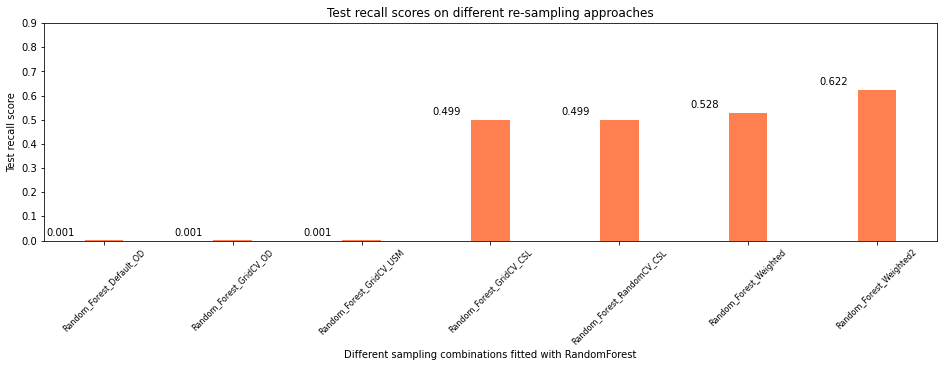

In [ ]:
fig = plt.figure(figsize = [16, 4])
plt.bar(model_comparison['Model'], model_comparison['Test_Recall'], color = 'coral', width=0.3)
plt.xlabel('Different sampling combinations fitted with RandomForest')
plt.ylabel('Test recall score')
plt.title('Test recall scores on different re-sampling approaches')
plt.xticks( rotation = 45, fontsize=8, horizontalalignment="center")
plt.yticks(np.arange(0, 0.95, 0.1))

for i, v in enumerate(model_comparison['Test_Recall']):
  plt.text(i-0.45, v+0.02, str(round(v, 3)))

plt.show()

GRID_CV_OD, GRID_CV_USM, GRID_CV_CSL, Weighted2

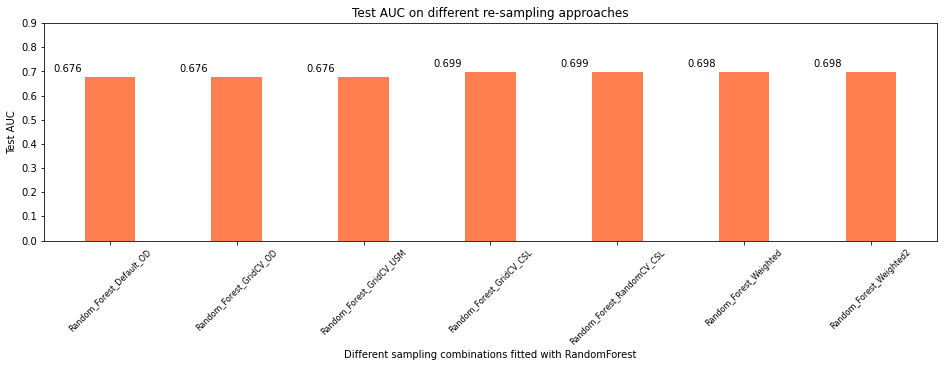

In [ ]:
fig = plt.figure(figsize = [16, 4])
plt.bar(model_comparison['Model'], model_comparison['Test_AUC'], color = 'coral', width=0.4)
plt.xlabel('Different sampling combinations fitted with RandomForest')
plt.ylabel('Test AUC')
plt.title('Test AUC on different re-sampling approaches')
plt.xticks( rotation = 45, fontsize=8, horizontalalignment="center")
plt.yticks(np.arange(0, 0.95, 0.1))

for i, v in enumerate(model_comparison['Test_AUC']):
  plt.text(i-0.45, v+0.02, str(round(v, 3)))

plt.show()

### Train Metrics

In [ ]:
##Creating a dataframe to store the accuracy, precision, recall values
#ROC, precision, recall, acccuracy

#Accuracy Train:  0.6759054136103316
#Precision Train: 0.16000551901761487
#Recall Train: 0.7007049345417925
#AUC score 0.7563718855082012

Comparison_dict = {'Random_Forest_Default_OD':[0.9999384630532171,1.0,0.9992447129909365,1.0],
                       'Random_Forest_GridCV_OD':[0.9999384630532171,1.0,0.9992447129909365,1.0],
                       'Random_Forest_GridCV_USM':[0.9996223564954683,1.0,0.9992447129909365,1.0],
                       'Random_Forest_GridCV_CSL':[0.7663770327704754,0.18956020959938394,0.5701409869083585,0.7567963704627501],
                       'Random_Forest_RandomCV_CSL':[0.757421112223298,0.1678170253078901,0.499496475327291,0.6986872053207669],
                       'Random_Forest_Weighted':[0.6759054136103316,0.16000551901761487, 0.7007049345417925,0.7563718855082012]}

model_comparison = pd.DataFrame(Comparison_dict)
model_comparison['Metrics'] = ['Train_Accuracy','Train_Precision','Train_Recall','Train_AUC']

#re-arranging the column order
cols = model_comparison.columns.tolist()
cols = cols[-1:] + cols[:-1]
model_comparison = model_comparison[cols]

#pivot
model_comparison = model_comparison.transpose()
model_comparison = model_comparison[1:].reset_index(drop=False)
model_comparison.columns = ['Model','Train_Accuracy','Train_Precision','Train_Recall','Train_AUC']
model_comparison

,Model,Train_Accuracy,Train_Precision,Train_Recall,Train_AUC
0,Random_Forest_Default_OD,0.999938,1,0.999245,1
1,Random_Forest_GridCV_OD,0.999938,1,0.999245,1
2,Random_Forest_GridCV_USM,0.999622,1,0.999245,1
3,Random_Forest_GridCV_CSL,0.766377,0.18956,0.570141,0.756796
4,Random_Forest_RandomCV_CSL,0.757421,0.167817,0.499496,0.698687
5,Random_Forest_Weighted,0.675905,0.160006,0.700705,0.756372
